## SET UP

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from string import digits
from collections import Counter
from pyvi import ViTokenizer
from gensim.models.word2vec import Word2Vec
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
%matplotlib inline

## DATA AGGREGATION

In [3]:
review_dtmtb = pd.read_csv('reviewData_dtmtb.csv')
review_dtdl = pd.read_csv('reviewData_dtdl.csv')
review_tbkts_pks = pd.read_csv('reviewData_tbkts_pks.csv')

NameError: name 'pd' is not defined

In [4]:
review_data = pd.concat([review_dtmtb, review_dtdl, review_tbkts_pks])

In [4]:
review_data.head()

,id,title,content,thank_count,customer_id,rating,created_at,customer_name,purchased_at
0,17206712,Cực kì hài lòng,"Mình vừa nhận được hàng, máy chạy tốt, pin sạc...",0,20468199,5,1658815564,NaN,NaN
1,17022830,Cực kì hài lòng,giao hàng đúng thời. điện thoại giao đúng mẫu....,3,21886251,5,1657513127,NaN,NaN
2,16990209,Cực kì hài lòng,giao hàng nhanh. đóng gói rất OK. mỗi tội tiếc...,5,14674088,5,1657279289,NaN,NaN
3,16618308,Cực kì hài lòng,Dùng siêu thích máy phiên bản 2022 và cùng năm...,1,14923716,5,1654645068,NaN,NaN
4,17056290,Cực kì hài lòng,cho tiki trading shop 5 sao!shop uy tín! giao ...,0,7966673,5,1657721825,NaN,NaN


In [5]:
review_data.value_counts('rating')

rating
5    92711
4    15936
1     7053
3     4882
2     2319
dtype: int64

In [6]:
review_data['content'].isna().sum()

45167

In [7]:
review_data.dropna(subset=['content'], inplace=True)

In [8]:
review_data['content'].isna().sum()

0

In [9]:
review_dtmtb.value_counts('title')

title
Cực kì hài lòng                                      16757
Hài lòng                                              2057
Rất không hài lòng                                     570
Bình thường                                            400
Không hài lòng                                         193
                                                     ...  
The perfect device to read on the go                     1
Thích                                                   1
Thông tin hàng không đúng                                1
Thất vọng về service giao 2h và hình thức đổi/hủy        1
10/10 về dịch vụ và sản phẩm                             1
Length: 480, dtype: int64

In [10]:
review_data.value_counts('rating')

rating
5    54361
4     9663
1     6990
3     4427
2     2293
dtype: int64

In [11]:
review_data['rating_class'] = review_data['rating'].apply(lambda x: 1 if x>3 else 0 if x==3 else -1)

In [12]:
review_data['rating_class'].value_counts()

 1    64024
-1     9283
 0     4427
Name: rating_class, dtype: int64

In [13]:
rating_data = review_data[['content','rating_class']]
rating_data = rating_data.rename(columns={'rating_class':"class"})
rating_data

,content,class
0,"Mình vừa nhận được hàng, máy chạy tốt, pin sạc...",1
1,giao hàng đúng thời. điện thoại giao đúng mẫu....,1
2,giao hàng nhanh. đóng gói rất OK. mỗi tội tiếc...,1
3,Dùng siêu thích máy phiên bản 2022 và cùng năm...,1
4,cho tiki trading shop 5 sao!shop uy tín! giao ...,1
...,...,...
41460,cực kỳ hài lòng,1
41461,"Sạc pin chỉ full 88%, nhờ shop tư vấn",-1
41462,nhìn rất ok.,1
41463,Giao hang nhah hang dung ok,1


In [14]:
data_train, data_test  = train_test_split(rating_data, test_size=0.2)

In [15]:
data_train.value_counts("class")

class
 1    51175
-1     7440
 0     3572
dtype: int64

In [16]:
data_test.value_counts("class")

class
 1    12849
-1     1843
 0      855
dtype: int64

In [19]:
data_train.to_csv('data_train.csv', index=False)
data_test.to_csv('data_test.csv', index=False)

## DATA PREPARATION

In [2]:
data_train = pd.read_csv('data_train.csv');
data_test = pd.read_csv('data_test.csv');

In [3]:
data_train.value_counts('class')

class
 1    51175
-1     7440
 0     3572
dtype: int64

In [4]:
from sklearn.utils import resample

In [5]:

data_train_1 = data_train[data_train['class'] == 1]
data_train_0 = data_train[data_train['class'] == 0]
data_train_n1 = data_train[data_train['class'] == -1]

data_train_1 = resample(data_train_1, replace=False, n_samples=3000, random_state=1)
data_train_0 = resample(data_train_0, replace=False, n_samples=3000, random_state=2)
data_train_n1 = resample(data_train_n1, replace=False, n_samples=3000, random_state=3)

data_train = pd.concat([data_train_1, data_train_0, data_train_n1])

In [6]:
data_train.value_counts('class')

class
-1    3000
 0    3000
 1    3000
dtype: int64

In [7]:
labels = data_train.iloc[:,1].values
reviews = data_train.iloc[:,0].values

In [8]:
encoded_labels = []
for label in labels:
    if label == -1:
        encoded_labels.append([1,0,0])
    elif label ==0:
        encoded_labels.append([0,1,0])
    else:
        encoded_labels.append([0,0,1])

encoded_labels = np.array(encoded_labels)

In [9]:
encoded_labels

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [10]:
reviews_processed = []
unlabeld_processed = []
for review in reviews:
    review_cool_one = ''.join([char for char in review if char not in digits])
    reviews_processed.append(review_cool_one)
    
print(reviews[0])
print(reviews_processed[0])

Khá hài lòng
Khá hài lòng


In [11]:
word_reviews = []
all_words = []
for review in reviews_processed:
    review = ViTokenizer.tokenize(review.lower())
    word_reviews.append(review.split())

print(word_reviews[0])

['khá', 'hài_lòng']


In [12]:
EMBEDDING_DIM = 400 #how big is each word vector
MAX_VOCAB_SIZE = 10000 #how many unique words to use
MAX_SEQUENCE_LENGTH = 300 #max number of words in a comment to use

In [13]:
#!pip3 install keras --user

In [14]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [15]:
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE, lower = True, char_level = False)
tokenizer.fit_on_texts(word_reviews)
sequences_train = tokenizer.texts_to_sequences(word_reviews)
word_index = tokenizer.word_index

In [16]:
data = pad_sequences(sequences_train, maxlen = MAX_SEQUENCE_LENGTH)
labels = encoded_labels

In [17]:
sub_data = data[:2000]
sub_labels = labels[:2000]

In [18]:
sub_data.shape

(2000, 300)

In [19]:
print('Shape of X train and X validation tensor', data.shape)
print('Shape of label train and validation tensor', labels.shape)

Shape of X train and X validation tensor (9000, 300)
Shape of label train and validation tensor (9000, 3)


In [20]:
vocabulary_size = min(len(word_index) +1, MAX_VOCAB_SIZE)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
# import gensim
# from gensim.models import Word2Vec
# from gensim.utils import simple_preprocess
# from gensim.models.keyedvectors import KeyedVectors

# word_vectors = KeyedVectors.load_word2vec_format('vi-model-CBOW.bin', binary = True)
# vocabulary_size = min(len(word_index) +1, MAX_VOCAB_SIZE)
# embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
# print("Vocab size with <UNK>:", vocabulary_size)

# for word, i in word_index.items():
#     if i>=MAX_VOCAB_SIZE:
#         continue
#     try:
#         embedding_vector = word_vectors[word]
#         embedding_matrix[i] = embedding_vector
#     except KeyError:
#         embedding_matrix[i] = np.random.normal(0, np.sqrt(0.25), EMBEDDING_DIM)
        
# del(word_vectors)

# from keras.layers import Embedding
# embedding_layer = Embedding(vocabulary_size, EMBEDDING_DIM, weights = [embedding_matrix],
#                            trainable = True)

## Test data preparation

In [22]:
labels_test = data_test.iloc[:, 1].values
reviews_test = data_test.iloc[:, 0].values

In [23]:
encoded_labels_test = []
for label_test in labels_test:
    if label_test == -1:
        encoded_labels_test.append([1,0,0])
    elif label_test ==0:
        encoded_labels_test.append([0,1,0])
    else:
        encoded_labels_test.append([0,0,1])
        
encoded_labels_test = np.array(encoded_labels_test)

In [24]:
reviews_processed_test = []
unlabeled_processed_test = []
for review_test in reviews_test:
    review_cool_one = ''.join([char for char in review_test if char not in digits])
    reviews_processed_test.append(review_cool_one)

In [25]:
word_reviews_test = []
all_words = []
for review_test in reviews_processed_test:
    review_test = ViTokenizer.tokenize(review_test.lower())
    word_reviews_test.append(review_test.split())

In [26]:
sequences_test = tokenizer.texts_to_sequences(word_reviews_test)
data_test = pad_sequences(sequences_test, maxlen = MAX_SEQUENCE_LENGTH)
labels_test = encoded_labels_test

In [27]:
print('Shape of X train and X validation tencor: ', data_test.shape)
print('Shape of label train and X validation tencor: ', labels_test.shape)

Shape of X train and X validation tencor:  (15547, 300)
Shape of label train and X validation tencor:  (15547, 3)


In [28]:
sub_data_test = data_test[:500]
sub_labels_test = labels_test[:500]

## LSTM

In [30]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM, Flatten, Bidirectional, Layer, Reshape, Input, Permute, Attention
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras import backend as K

In [80]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_LSTM.add(LSTM(128, dropout = 0.1, return_sequences = False))
model_LSTM.add(Dense(10, activation='relu'))
model_LSTM.add(Dense(3, activation='softmax'))
model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [81]:
model_LSTM.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 300, 400)          4000000   
                                                                 
 lstm_16 (LSTM)              (None, 128)               270848    
                                                                 
 dense_23 (Dense)            (None, 10)                1290      
                                                                 
 dense_24 (Dense)            (None, 3)                 33        
                                                                 
Total params: 4,272,171
Trainable params: 4,272,171
Non-trainable params: 0
_________________________________________________________________


In [82]:
early_stopping = EarlyStopping(monitor = 'loss', min_delta = 0.1, patience = 4, verbose = 1)
callbacks_list = [early_stopping]

In [84]:
history = model_LSTM.fit(sub_data, sub_labels, epochs=100, batch_size=256, callbacks=callbacks_list, verbose = 1,shuffle = True, validation_data=[sub_data_test, sub_labels_test])

Epoch 1/100
8/8 [==============================] - 19s 2s/step - loss: 0.0535 - acc: 1.0000 - val_loss: 1.2864 - val_acc: 0.8180
Epoch 2/100
8/8 [==============================] - 19s 2s/step - loss: 0.0011 - acc: 1.0000 - val_loss: 1.6265 - val_acc: 0.8180
Epoch 3/100
8/8 [==============================] - 18s 2s/step - loss: 2.3276e-04 - acc: 1.0000 - val_loss: 1.8017 - val_acc: 0.8180
Epoch 4/100
8/8 [==============================] - 18s 2s/step - loss: 1.0548e-04 - acc: 1.0000 - val_loss: 1.8901 - val_acc: 0.8180
Epoch 5/100
8/8 [==============================] - 18s 2s/step - loss: 7.1061e-05 - acc: 1.0000 - val_loss: 1.9352 - val_acc: 0.8180
Epoch 5: early stopping


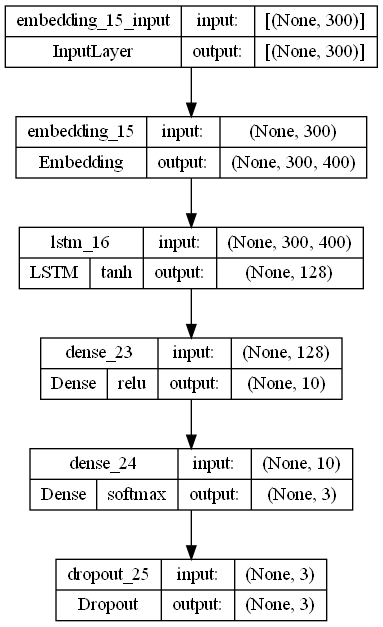

In [102]:
tf.keras.utils.plot_model(model_LSTM, to_file='model_LSTM.png', show_shapes=True, show_layer_activations=True)

In [85]:
score = model_LSTM.evaluate(data_test, labels_test)

print("%s: %.2f" %(model_LSTM.metrics_names[0], score[0]))
print("%s: %.2f%%" %(model_LSTM.metrics_names[1], score[1]*100))

486/486 [==============================] - 55s 113ms/step - loss: 1.8715 - acc: 0.8265
loss: 1.87
acc: 82.65%


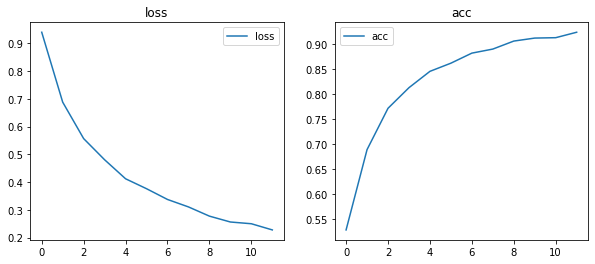

In [46]:
def plot_loss_accuracy(history):
    fig, axs = plt.subplots(1,2, figsize = (10, 4))
    hist = history.history
    for ax, metric in zip(axs, ["loss", "acc"]):
        ax.plot(hist[metric])
        ax.legend([metric])
        ax.set_title(metric)
    plt.style.use('default')
    
plot_loss_accuracy(history)

In [35]:
prediction = model_LSTM.predict(data_test[:10])

labels_text = ['Tiêu cực', 'Bình thường', 'Tích cực']

1/1 [==============================] - 1s 806ms/step


In [37]:
prediction

array([[0.00722548, 0.08816306, 0.9522633 ],
       [0.00654785, 0.08554897, 0.95476377],
       [0.0072378 , 0.08823227, 0.95221585],
       [0.00695252, 0.08751168, 0.95320773],
       [0.00738691, 0.0886574 , 0.95169765],
       [0.0069138 , 0.08751731, 0.9533304 ],
       [0.00709095, 0.08770426, 0.95274466],
       [0.00697053, 0.08746839, 0.953156  ],
       [0.00721297, 0.08829553, 0.9522851 ],
       [0.00705445, 0.08781047, 0.95284605]], dtype=float32)

In [36]:
num=2
print(reviews_test[num])
print(labels_text[np.argmax(labels_test[num])])
print(labels_text[np.argmax(prediction[num])])

Hàng chính hãng, tuy nhiên giao hàng vẫn ko đúng hẹn
Tích cực
Tích cực


## Bi-LSTM

In [86]:
model_Bi_LSTM = Sequential()
model_Bi_LSTM.add(Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_Bi_LSTM.add(Bidirectional(LSTM(128, dropout = 0.1, return_sequences = False)))
model_Bi_LSTM.add(Dense(64, activation='relu'))
model_Bi_LSTM.add(Dense(3, activation='sigmoid'))
model_Bi_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [87]:
model_Bi_LSTM.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 300, 400)          4000000   
                                                                 
 bidirectional_5 (Bidirectio  (None, 256)              541696    
 nal)                                                            
                                                                 
 dense_25 (Dense)            (None, 64)                16448     
                                                                 
 dense_26 (Dense)            (None, 3)                 195       
                                                                 
Total params: 4,558,339
Trainable params: 4,558,339
Non-trainable params: 0
_________________________________________________________________


In [105]:
history = model_Bi_LSTM.fit(data, labels, epochs=100, batch_size=256, callbacks=callbacks_list, verbose = 1,shuffle = True, validation_data=[data_test, labels_test])

Epoch 1/100
36/36 [==============================] - 325s 9s/step - loss: 0.4081 - acc: 0.8441 - val_loss: 0.6474 - val_acc: 0.7801
Epoch 2/100
36/36 [==============================] - 324s 9s/step - loss: 0.3354 - acc: 0.8770 - val_loss: 0.6702 - val_acc: 0.7822
Epoch 3/100
36/36 [==============================] - 327s 9s/step - loss: 0.2837 - acc: 0.8986 - val_loss: 0.6467 - val_acc: 0.7955
Epoch 4/100
36/36 [==============================] - 325s 9s/step - loss: 0.2454 - acc: 0.9123 - val_loss: 0.8407 - val_acc: 0.7587
Epoch 5/100
36/36 [==============================] - 326s 9s/step - loss: 0.2187 - acc: 0.9251 - val_loss: 1.0111 - val_acc: 0.7124
Epoch 6/100
36/36 [==============================] - 369s 10s/step - loss: 0.1929 - acc: 0.9340 - val_loss: 1.1062 - val_acc: 0.7089
Epoch 7/100
36/36 [==============================] - 347s 10s/step - loss: 0.1880 - acc: 0.9324 - val_loss: 0.9761 - val_acc: 0.7475
Epoch 7: early stopping


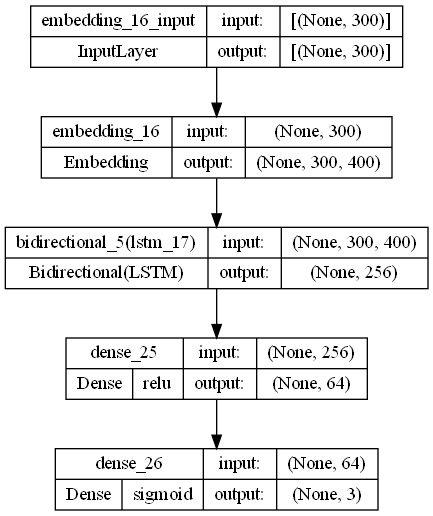

In [109]:
tf.keras.utils.plot_model(model_Bi_LSTM, to_file='model_Bi_LSTM.png', show_shapes=True, show_layer_activations=True)

In [110]:
score = model_Bi_LSTM.evaluate(data_test, labels_test)

print("%s: %.2f" %(model_Bi_LSTM.metrics_names[0], score[0]))
print("%s: %.2f%%" %(model_Bi_LSTM.metrics_names[1], score[1]*100))

486/486 [==============================] - 150s 309ms/step - loss: 0.9761 - acc: 0.7475
loss: 0.98
acc: 74.75%


## Bi LSTM Attention

In [32]:
from tensorflow.keras.layers import Concatenate
from keras import regularizers
from keras.models import Model
import keras

In [36]:
# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)
 
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)
 
    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [37]:
sequence_length = sub_data.shape[1]
drop = 0.1

inputs = Input(shape = (sequence_length,))
embedding = Embedding(vocabulary_size, EMBEDDING_DIM, weights = [embedding_matrix])(inputs)
bilstm = Bidirectional(LSTM(128, return_sequences = True))(embedding)
attention_layer = attention()(bilstm)
output = Dense(units = 3, activation = 'softmax')(attention_layer)

model_bi_lstm_att = Model(inputs, output)

In [56]:
# Retrieve the config
config = model_bi_lstm_att.get_config()

# At loading time, register the custom objects with a `custom_object_scope`:
custom_objects = {"attention": attention}
with keras.utils.custom_object_scope(custom_objects):
    new_model_bi_lstm_att = keras.Model.from_config(config)

In [104]:
model_Bi_LSTM_att = Sequential()
model_Bi_LSTM_att.add(Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_Bi_LSTM_att.add(Bidirectional(LSTM(128, dropout = 0.1, return_sequences = False)))
model_Bi_LSTM_att.add(Attention())
model_Bi_LSTM_att.add(Dense(64, activation='relu'))
model_Bi_LSTM_att.add(Dense(3, activation='sigmoid'))
model_Bi_LSTM_att.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_Bi_LSTM_att.summary()

ValueError: Exception encountered when calling layer "attention_1" (type Attention).

Attention layer must be called on a list of inputs, namely [query, value] or [query, value, key]. Received: Tensor("Placeholder:0", shape=(None, 256), dtype=float32).

Call arguments received by layer "attention_1" (type Attention):
  • inputs=tf.Tensor(shape=(None, 256), dtype=float32)
  • mask=None
  • training=False
  • return_attention_scores=False

In [59]:
new_model_bi_lstm_att.fit(data, labels,epochs = 100, batch_size = 256, callbacks = callbacks_list, verbose = 1,shuffle = True, validation_data=[data_test, labels_test])

Epoch 1/100
36/36 [==============================] - 320s 9s/step - loss: 1.1017 - accuracy: 0.3560 - val_loss: 1.0618 - val_accuracy: 0.8047
Epoch 2/100
36/36 [==============================] - 325s 9s/step - loss: 0.9940 - accuracy: 0.4988 - val_loss: 0.7593 - val_accuracy: 0.6711
Epoch 3/100
36/36 [==============================] - 331s 9s/step - loss: 0.8365 - accuracy: 0.6057 - val_loss: 0.8184 - val_accuracy: 0.7463
Epoch 4/100
36/36 [==============================] - 333s 9s/step - loss: 0.7561 - accuracy: 0.6699 - val_loss: 0.9470 - val_accuracy: 0.5918
Epoch 5/100
36/36 [==============================] - 331s 9s/step - loss: 0.6536 - accuracy: 0.7267 - val_loss: 0.7007 - val_accuracy: 0.7461
Epoch 6/100
36/36 [==============================] - 336s 9s/step - loss: 0.5401 - accuracy: 0.7873 - val_loss: 0.8877 - val_accuracy: 0.7214
Epoch 7/100
36/36 [==============================] - 335s 9s/step - loss: 0.4682 - accuracy: 0.8220 - val_loss: 0.5709 - val_accuracy: 0.8018
Epoch 

In [116]:
score = new_model_bi_lstm_att.evaluate(data_test, labels_test)

print("%s: %.2f" %(model_CNN_3conv.metrics_names[0], score[0]))
print("%s: %.2f%%" %(model_CNN_3conv.metrics_names[1], score[1]*100))

486/486 [==============================] - 125s 258ms/step - loss: 0.7426 - accuracy: 0.7634
loss: 0.74
accuracy: 76.34%


In [60]:
prediction = new_model_bi_lstm_att.predict(data_test[:10])

labels_text = ['Tiêu cực', 'Bình thường', 'Tích cực']
num=2
print(reviews_test[num])
print(labels_text[np.argmax(labels_test[num])])
print(labels_text[np.argmax(prediction[num])])

1/1 [==============================] - 1s 1s/step
Hàng chính hãng, tuy nhiên giao hàng vẫn ko đúng hẹn
Tích cực
Tích cực


## CNN

In [54]:

from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, LayerNormalization, TimeDistributed

In [106]:

model_CNN = Sequential()
model_CNN.add(Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_CNN.add(Dropout(0.1))
model_CNN.add(Conv1D(filters=32, kernel_size=3, padding="same", activation="relu"))
model_CNN.add(MaxPooling1D())
model_CNN.add(Dropout(0.1))
model_CNN.add(Flatten())
model_CNN.add(Dense(units = 3, activation = 'softmax'))

model_CNN.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_CNN. summary()


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 300, 400)          4000000   
                                                                 
 dropout_29 (Dropout)        (None, 300, 400)          0         
                                                                 
 conv1d_28 (Conv1D)          (None, 300, 32)           38432     
                                                                 
 max_pooling1d_31 (MaxPoolin  (None, 150, 32)          0         
 g1D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 150, 32)           0         
                                                                 
 flatten_13 (Flatten)        (None, 4800)              0         
                                                     

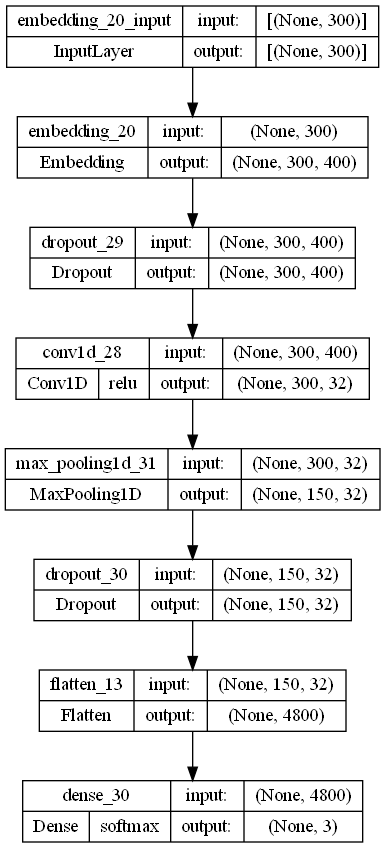

In [107]:
tf.keras.utils.plot_model(model_CNN, to_file='model_CNN_LSTM.png', show_shapes=True, show_layer_activations=True)

In [98]:
model_CNN.fit(data, labels,epochs = 100, batch_size = 256, callbacks = callbacks_list, verbose = 1,shuffle = True, validation_data=[data_test, labels_test])

Epoch 1/100
36/36 [==============================] - 37s 1s/step - loss: 0.8530 - accuracy: 0.5873 - val_loss: 0.6397 - val_accuracy: 0.7701
Epoch 2/100
36/36 [==============================] - 38s 1s/step - loss: 0.6501 - accuracy: 0.7106 - val_loss: 0.7308 - val_accuracy: 0.7408
Epoch 3/100
36/36 [==============================] - 36s 1s/step - loss: 0.5264 - accuracy: 0.7937 - val_loss: 0.6759 - val_accuracy: 0.7722
Epoch 4/100
36/36 [==============================] - 37s 1s/step - loss: 0.4244 - accuracy: 0.8364 - val_loss: 0.6233 - val_accuracy: 0.7984
Epoch 5/100
36/36 [==============================] - 34s 941ms/step - loss: 0.3501 - accuracy: 0.8712 - val_loss: 0.7048 - val_accuracy: 0.7960
Epoch 6/100
36/36 [==============================] - 35s 990ms/step - loss: 0.2854 - accuracy: 0.9022 - val_loss: 0.7770 - val_accuracy: 0.7800
Epoch 7/100
36/36 [==============================] - 36s 999ms/step - loss: 0.2314 - accuracy: 0.9206 - val_loss: 0.8302 - val_accuracy: 0.7747
Epoc

In [100]:
score = model_CNN.evaluate(data_test, labels_test)

print("%s: %.2f" %(model_CNN.metrics_names[0], score[0]))
print("%s: %.2f%%" %(model_CNN.metrics_names[1], score[1]*100))

486/486 [==============================] - 6s 12ms/step - loss: 1.1295 - accuracy: 0.7762
loss: 1.13
accuracy: 77.62%


In [74]:
prediction = model_CNN.predict(data_test[:10])

labels_text = ['Tiêu cực', 'Bình thường', 'Tích cực']
num=2
print(reviews_test[num])
print(labels_text[np.argmax(labels_test[num])])
print(labels_text[np.argmax(prediction[num])])

1/1 [==============================] - 0s 105ms/step
Hàng chính hãng, tuy nhiên giao hàng vẫn ko đúng hẹn
Tích cực
Tích cực


## CNN + LSTM 

In [38]:
inputs = Input(shape = (sequence_length,))
initializer = tf.keras.initializers.GlorotNormal()
embedding = Embedding(vocabulary_size, EMBEDDING_DIM, weights = [embedding_matrix],  embeddings_initializer="GlorotNormal")(inputs)
drop=0.4
#CNN

cnn_feature = Conv1D(filters=32, kernel_size=3, padding="same", activation="relu")(embedding)
cnn_feature = MaxPooling1D()(cnn_feature)
cnn_feature = Dropout(drop)(cnn_feature)

cnn_feature = Conv1D(filters=32, kernel_size=3, padding="same", activation="relu")(cnn_feature)
cnn_feature = MaxPooling1D()(cnn_feature)
cnn_feature = Dropout(drop)(cnn_feature)

# cnn_feature = Conv1D(filters=32, kernel_size=3, padding="same", activation="relu")(cnn_feature)
# cnn_feature = MaxPooling1D()(cnn_feature)
# cnn_feature = Dropout(drop)(cnn_feature)

# cnn_feature = Conv1D(filters=32, kernel_size=3, padding="same", activation="relu")(cnn_feature)
# cnn_feature = MaxPooling1D()(cnn_feature)
# cnn_feature = Dropout(drop)(cnn_feature)

cnn_feature = Conv1D(filters=32, kernel_size=3, padding="same", activation="relu")(cnn_feature)
cnn_feature = MaxPooling1D()(cnn_feature)
cnn_feature = LayerNormalization()(cnn_feature)
cnn_feature = Dropout(drop)(cnn_feature)



# #LSTM
bi_lstm_feature = Bidirectional(LSTM(units=32,  dropout=drop, return_sequences = True))(embedding)
bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)

bi_lstm_feature = Bidirectional(LSTM(units=32,  dropout=drop, return_sequences = True))(bi_lstm_feature)
bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)

bi_lstm_feature = Bidirectional(LSTM(units=32,  dropout=drop, return_sequences = True))(bi_lstm_feature)
#bi_lstm_feature = attention()(bi_lstm_feature)
#bi_lstm_feature = GlobalMaxPooling1D()(bi_lstm_feature)
bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)
bi_lstm_feature = LayerNormalization()(bi_lstm_feature)

#Combine
combine_feature = tf.keras.layers.Concatenate()([cnn_feature, bi_lstm_feature])
combine_feature = GlobalMaxPooling1D()(combine_feature)
combine_feature = LayerNormalization()(combine_feature)
combine_feature = Dense(16,activation='relu')(combine_feature)

output = Dense(units = 3, activation = 'softmax')(combine_feature)

model_CNN_LSTM = Model(inputs, output)


adam = Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.0)
model_CNN_LSTM.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
model_CNN_LSTM. summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 300, 400)     2869600     ['input_3[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 300, 32)      38432       ['embedding_2[0][0]']            
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 150, 32)      0           ['conv1d[0][0]']                 
                                                                                            

In [67]:
model_CNN_LSTM = Sequential()
model_CNN_LSTM.add(Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model_CNN_LSTM.add(Dropout(0.1))
model_CNN_LSTM.add(Conv1D(filters=32, kernel_size=3, padding="same", activation="relu"))
model_CNN_LSTM.add(MaxPooling1D())
model_CNN_LSTM.add(Dropout(0.1))
model_CNN_LSTM.add(LSTM(units=32,  dropout=drop, return_sequences = True))
model_CNN_LSTM.add(Flatten())
model_CNN_LSTM.add(Dense(units = 3, activation = 'softmax'))

adam = Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.0)
model_CNN_LSTM.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
model_CNN_LSTM. summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 300, 400)          4000000   
                                                                 
 dropout_16 (Dropout)        (None, 300, 400)          0         
                                                                 
 conv1d_22 (Conv1D)          (None, 300, 32)           38432     
                                                                 
 max_pooling1d_25 (MaxPoolin  (None, 150, 32)          0         
 g1D)                                                            
                                                                 
 lstm_14 (LSTM)              (None, 150, 32)           8320      
                                                                 
 flatten_8 (Flatten)         (None, 4800)              0         
                                                     

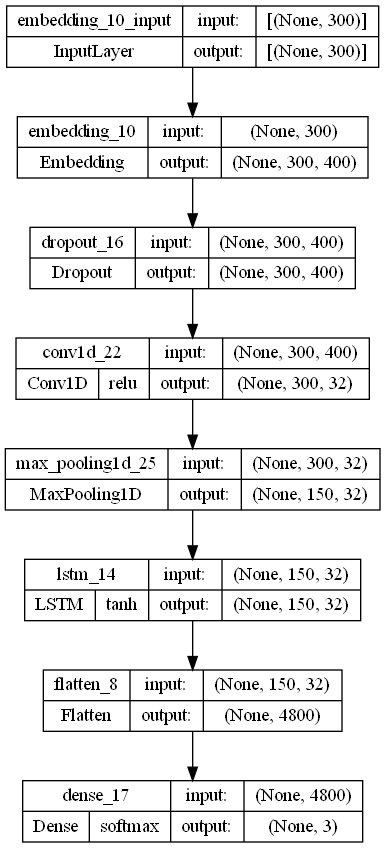

In [92]:
tf.keras.utils.plot_model(model_CNN_LSTM, to_file='model_CNN_LSTM.png', show_shapes=True, show_layer_activations=True)

In [68]:
model_CNN_LSTM.fit(sub_data, sub_labels,epochs = 100, batch_size = 256, callbacks = callbacks_list, verbose = 1,shuffle = True, validation_data=[sub_data_test, sub_labels_test])

Epoch 1/100
8/8 [==============================] - 10s 932ms/step - loss: 0.4140 - accuracy: 0.8720 - val_loss: 1.9424 - val_accuracy: 0.8180
Epoch 2/100
8/8 [==============================] - 7s 893ms/step - loss: 8.6879e-06 - accuracy: 1.0000 - val_loss: 4.8836 - val_accuracy: 0.8180
Epoch 3/100
8/8 [==============================] - 7s 931ms/step - loss: 1.7285e-09 - accuracy: 1.0000 - val_loss: 6.5631 - val_accuracy: 0.8180
Epoch 4/100
8/8 [==============================] - 8s 972ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 7.4104 - val_accuracy: 0.8180
Epoch 5/100
8/8 [==============================] - 7s 911ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 7.8221 - val_accuracy: 0.8180
Epoch 6/100
8/8 [==============================] - 7s 886ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 8.0178 - val_accuracy: 0.8180
Epoch 6: early stopping


In [69]:
score = model_CNN_LSTM.evaluate(data_test, labels_test)

print("%s: %.2f" %(model_CNN_3conv.metrics_names[0], score[0]))
print("%s: %.2f%%" %(model_CNN_3conv.metrics_names[1], score[1]*100))

486/486 [==============================] - 11s 22ms/step - loss: 7.6324 - accuracy: 0.8265
loss: 7.63
accuracy: 82.65%


In [118]:
prediction = model_CNN_LSTM.predict(data_test[:10])

labels_text = ['Tiêu cực', 'Bình thường', 'Tích cực']
num=2
print(reviews_test[num])
print(labels_text[np.argmax(labels_test[num])])
print(labels_text[np.argmax(prediction[num])])

1/1 [==============================] - 0s 113ms/step
Hàng chính hãng, tuy nhiên giao hàng vẫn ko đúng hẹn
Tích cực
Tích cực
